In [1]:
import selectivesearch
from skimage.segmentation import felzenszwalb
from torch_snippets import *

In [2]:
img_cloud = read('C:/full_sky/image_10_L_L.png',1)

In [3]:
segment_fz_cloud = felzenszwalb(img_cloud,scale=200)

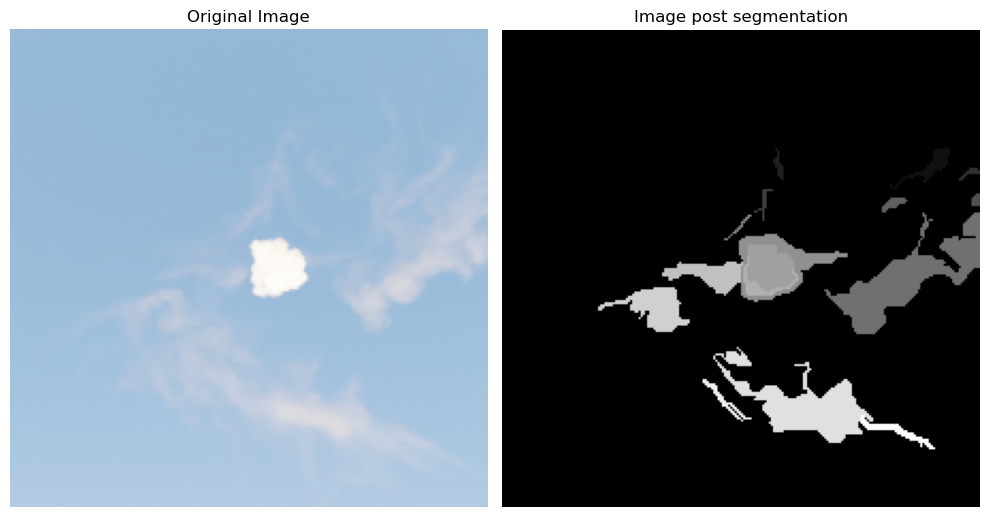

In [4]:

subplots([img_cloud,segment_fz_cloud], titles=['Original Image',"Image post segmentation"],sz=10,nc=2)

In [188]:
segment_fz = felzenszwalb(img,scale=200)

In [8]:
# Selective search for generating region proposals

# Selective search outputs img pixel, and regions dictionary with key 'rect'

def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img,scale=200,min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x,y,w,h = r['rect']
        candidates.append(list(r['rect']))
    return candidates

In [10]:
# Compute Intersection over Union (IoU) to find the perfect bounding box

def get_iou(boxA,boxB, epsilon=1e-5):
    # Calculate the coordinates of the intersection box
    x1 = max(boxA[0],boxB[0])
    y1 = max(boxA[1],boxB[1])
    x2 = min(boxA[2],boxB[2])
    y2 = min(boxA[3],boxB[3])
    
    # Intersection width and height
    width = (x2-x1)
    height = (y2-y1)
    
    if (width<0 or height<0):
        return 0.0
    
    area_overlap = width*height
    
    # Calculate A and B and AUB
    area_a = (boxA[2]-boxA[0]) * (boxA[3]-boxA[1])
    area_b = (boxB[2]-boxB[0]) * (boxB[3]-boxB[1])
    area_combined = area_a + area_b - area_overlap
    
    # iou = area_overlap / area_combined
    iou = area_overlap/area_combined
    return iou
    
    

In [11]:
IMAGE_ROOT = 'C:/Users/rd238422/ObjectDetection/dataset/images/images/'
DF_RAW = pd.read_csv('C:/Users/rd238422/ObjectDetection/dataset/df.csv')
df = DF_RAW.copy()
df=df[df['ImageID']=='00a4decd12ae97b9']
df['LabelName'].values.tolist()

['Bus']

In [12]:
# Making datasets to fetch the image and it's bounding box coordinates
class OpenImages(Dataset):
    def __init__(self, df, image_folder = IMAGE_ROOT):
        self.root = image_folder
        self.df = df
        self.unique_images = df['ImageID'].unique()
        
    def __len__(self):
        return len(self.unique_images)
    
    def __getitem__(self,ix):
        image_id = self.unique_images[ix]
        image_path = f'{self.root}/{image_id}.jpg'
        # Converting BGR image to RGB
        image = cv2.imread(image_path,1)[...,::-1]
        h,w,_ = image.shape
        df = self.df.copy()
        df = df[df['ImageID']==image_id]
        boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
        boxes = (boxes*np.array([w,h,w,h])).astype(np.uint16).tolist()
        classes = df['LabelName'].values.tolist()
        return image,boxes,classes,image_path
                

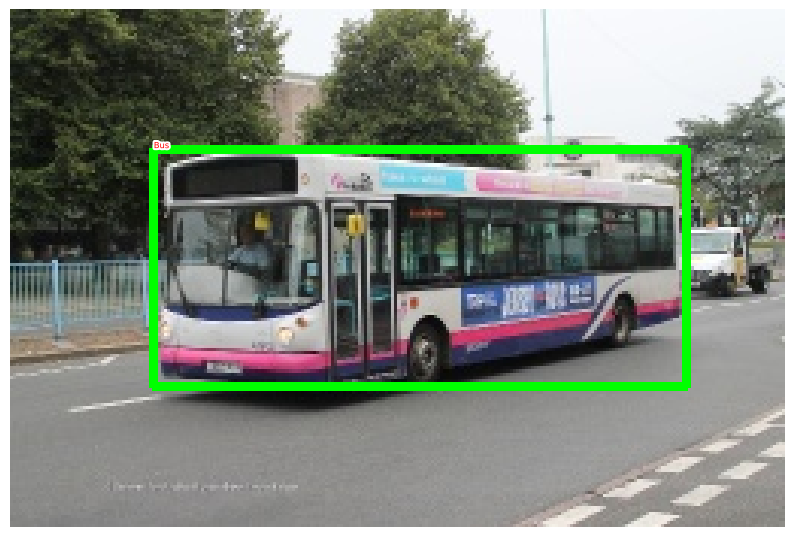

In [13]:
ds = OpenImages(df=DF_RAW)
im,bbs,clss,_ = ds[13000]
show(im,bbs=bbs,texts=clss,sz=10)

In [14]:
'XMin,YMin,XMax,YMax'.split(',')

['XMin', 'YMin', 'XMax', 'YMax']

In [15]:
# Initializing empty list to store the FPATHS, GTBBS (Ground Truth Bounding boxes), CLasses, Deltas , ROIs and Ious
FPATHS, GTBBS, CLSS,DELTAS, ROIS, IOUS = [],[],[],[],[],[]

# Taking 500 Datapoints first
N = 500
for ix,(im,bbs,labels,fpath) in enumerate(ds):
    if (ix==500):
        break
    H, W,_ = im.shape
    candidates = extract_candidates(im)
    candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates]) # convert to absolute pixel values to region coordinates
    # initializing ious, rois, deltas and clss that lists for each candidates
    # We will go throught all the proposals from selective search but store those with hight 
    # iou 
    ious, rois, clss, deltas = [],[],[],[]
    ious = np.array([[get_iou(candidate,__bb__) for candidate in candidates] for __bb__ in bbs]).T
    
    # loop through all the candidates and find the best iou among them and save it. 
    for jx, candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate
        candidate_ious = ious[jx]
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x,_y,_X,_Y = bbs[best_iou_at]
        
        # If IoU is greater than a threshold say 0.3 then we assign a label else background
        if best_iou > 0.3:
            clss.append(labels[best_iou_at])
        else:
            clss.append('background')
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
        deltas.append(delta)
        rois.append(candidate/np.array([W,H,W,H]))
    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    GTBBS.append(bbs)
FPATHS = [f'{IMAGE_ROOT}/{stem(f)}.jpg' for f in FPATHS] 
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in \
                                 [FPATHS, GTBBS, \
                                      CLSS, DELTAS, ROIS]]

C:\Users\rd238422\AppData\Local\miniconda3\envs\learnTorch\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
C:\Users\rd238422\AppData\Local\miniconda3\envs\learnTorch\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
C:\Users\rd238422\AppData\Local\miniconda3\envs\learnTorch\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are presen

In [16]:
candidates=extract_candidates(im)

C:\Users\rd238422\AppData\Local\miniconda3\envs\learnTorch\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [170]:
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {l:t for t,l in label2target.items()}
background_class = label2target['background']

background_class

1

In [18]:
# Creating the training dataset
normalize = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])

In [19]:

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()
def decode(_y):
    _, preds = _y.max(-1)
    return preds

In [20]:
def decode(_y):
    _,preds = _y.max(-1)
    return preds

In [21]:
class RCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1]
        H, W, _ = image.shape
        sh = np.array([W,H,W,H])
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        bbs = (np.array(rois)*sh).astype(np.uint16)
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        crops = [image[y:Y,x:X] for (x,y,X,Y) in bbs]
        return image, crops, bbs, labels, deltas, gtbbs, fpath
    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas = [], [], [], [], []
        for ix in range(len(batch)):
            image, crops, image_bbs, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            crops = [cv2.resize(crop, (224,224)) for crop in crops]
            crops = [preprocess_image(crop/255.)[None] for crop in crops]
            input.extend(crops)
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
        input = torch.cat(input).to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, labels, deltas


In [22]:
n_train = 9*len(FPATHS)//10
train_ds = RCNNDataset(FPATHS[:n_train],ROIS[:n_train],CLSS[:n_train],DELTAS[:n_train],GTBBS[:n_train])
test_ds = RCNNDataset(FPATHS[n_train:],ROIS[n_train:],CLSS[n_train:],DELTAS[n_train:],GTBBS[n_train:])

In [23]:
# Creating the dataloaders
from torch.utils.data import TensorDataset, DataLoader
train_loader = DataLoader(train_ds,batch_size=2,collate_fn=train_ds.collate_fn,drop_last=True)
test_loader = DataLoader(test_ds,batch_size=2,collate_fn=test_ds.collate_fn,drop_last=True)

In [24]:
from torchvision import models
vgg_backbone = models.vgg16(pretrained=True)
vgg_backbone.classifier = nn.Sequential()
for param in vgg_backbone.parameters():
    param.requires_grad = False
vgg_backbone.eval().to(device)

C:\Users\rd238422\AppData\Local\miniconda3\envs\learnTorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\rd238422\AppData\Local\miniconda3\envs\learnTorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [25]:
class RCNN(nn.Module):
    def __init__(self):
        super().__init__()
        feature_dim = 25088
        self.backbone = vgg_backbone
        self.cls_score = nn.Linear(feature_dim, len(label2target))
        self.bbox = nn.Sequential(
              nn.Linear(feature_dim, 512),
              nn.ReLU(),
              nn.Linear(512, 4),
              nn.Tanh(),
            )
        self.cel = nn.CrossEntropyLoss()
        self.sl1 = nn.L1Loss()
    def forward(self, input):
        feat = self.backbone(input)
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat)
        return cls_score, bbox
    def calc_loss(self, probs, _deltas, labels, deltas):
        detection_loss = self.cel(probs, labels)
        ixs, = torch.where(labels != 0)
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
        else:
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss
     

In [26]:
def train_batch(inputs, model, optimizer, criterion):
    input, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(input)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [27]:
# Validating the datasets
@torch.no_grad()
def validate_batch(inputs,model,criterion):
    input_img,clss,deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input_img)
        loss,loc_loss,regr_loss = criterion(_clss,_deltas,clss,deltas)
        _,_clss = _clss.max(-1)
        accs = clss = _clss
        return _clss,_deltas,loss.detach(),loc_loss,regr_loss,accs.cpu().numpy()

In [28]:
rcnn = RCNN().to(device)
criterion = rcnn.calc_loss
optimizer = optim.SGD(rcnn.parameters(),lr=1e-3)
n_epochs = 5
log = Report(n_epochs)

C:\Users\rd238422\AppData\Local\Temp\ipykernel_23484\4275183504.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  deltas = torch.Tensor(deltas).float().to(device)


EPOCH: 5.000  val_loss: 1.899  val_loc_loss: 0.499  val_regr_loss: 0.140  val_acc: 1.143  (431.33s - 0.00s remaining)))))

100%|██████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 4658.19it/s]


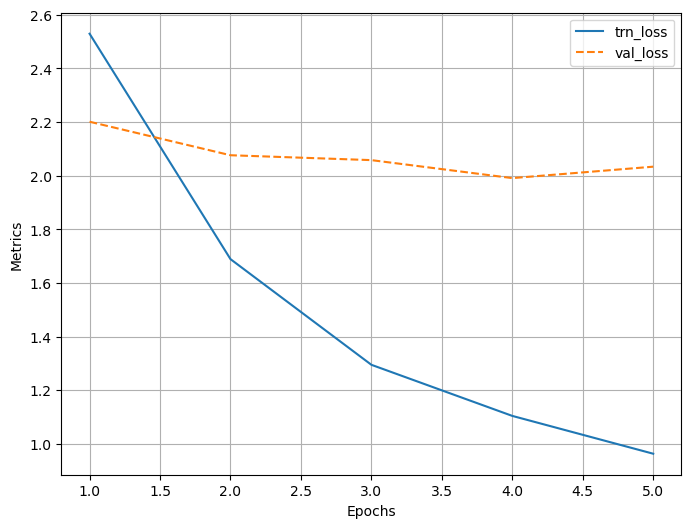

In [29]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix,inputs in enumerate(train_loader):
        loss,loc_loss,regr_loss,accs = train_batch(inputs,rcnn,optimizer,criterion)
        pos = (epoch+(ix+1)/_n)
        log.record(pos,trn_loss=loss.item(),trn_loc_loss=loc_loss,trn_regr_loss=regr_loss,trn_acc=accs.mean(),end='\r')
        
    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        _clss,_deltas,loss,loc_loss,regr_loss,accs = validate_batch(inputs,rcnn,criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos,val_loss=loss.item(),val_loc_loss=loc_loss,val_regr_loss=regr_loss,val_acc=accs.mean(),end='\r')
log.plot_epochs('trn_loss,val_loss'.split(','))

In [189]:
def test_predictions(filename, show_output=True):
    img = np.array(cv2.imread(filename, 1)[...,::-1])
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = []
    for candidate in candidates:
        x,y,X,Y = candidate
        crop = cv2.resize(img[y:Y,x:X], (224,224))
        input.append(preprocess_image(crop/255.)[None])
    input = torch.cat(input).to(device)
    with torch.no_grad():
        rcnn.eval()
        probs, deltas = rcnn(input)
        probs = torch.nn.functional.softmax(probs, -1)
        confs, clss = torch.max(probs, -1)
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]

    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = (candidates + deltas).astype(np.uint16)
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(confs) == 0 and not show_output:
        return (0,0,224,224), 'background', 0
    if len(confs) > 0:
        best_pred = np.argmax(confs)
        best_conf = np.max(confs)
        best_bb = bbs[best_pred]
        x,y,X,Y = best_bb
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title('Original image')
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    ax[1].set_title(target2label[clss[best_pred]])
    show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1], title='predicted bounding box and class')
    plt.show()
    return (x,y,X,Y),target2label[clss[best_pred]],best_conf

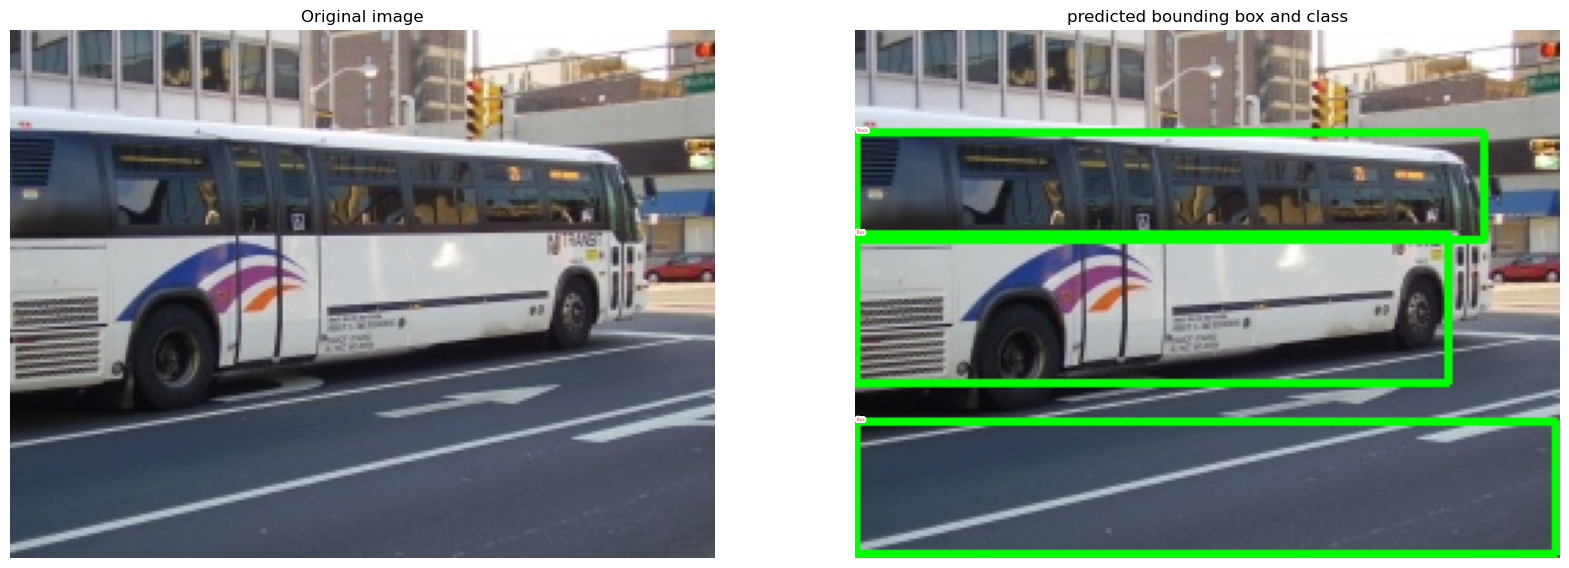

((0, 74, 215, 128), 'Bus', 0.58687204)

In [190]:
# Plotting the image with the predicted bounding box
# image, crops, bbs, labels, deltas, gtbbs, fpath = test_ds[7]
test_predictions(test_ds.fpaths[2])


In [45]:
import torch
print(torch.cuda.is_available())

True

In [36]:
# FastRCNN Implementation

class FRCNNDataset(Dataset):
    def __init__(self,fpaths,rois,labels,deltas,gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.deltas = deltas
        self.labels = labels
    
    def __len__(self):
        return len(self.fpaths)
    
    def __getitem__(self,ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath,1)[...,::-1]
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        return image,rois,labels,deltas,gtbbs
    def collate_fn(self,batch):
        input,rois,rixs,labels,deltas = [],[],[],[],[]
        for ix in range(len(batch)):
            image,image_rois,image_labels,image_deltas,image_gtbbs = batch[ix]
            image = cv2.resize(image,(224,224))
            input.append(preprocess_image(image/255.)[None])
            rois.extend(image_rois)
            rixs.extend([ix]*len(image_rois)) # ([1]*2 = [1,1])
            labels.extend(label2target[c] for c in image_labels) # For appending whole list
            deltas.extend(image_deltas)
        input = torch.cat(input).to(device)
        rois = torch.Tensor(rois).float().to(device)
        rixs = torch.Tensor(rixs).float().to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input,rois,rixs,labels,deltas

In [108]:
# creating testing and testing datasets

n_train = 9*len(FPATHS)//10
train_ds = FRCNNDataset(FPATHS[:n_train], ROIS[:n_train], \
                        CLSS[:n_train], DELTAS[:n_train], \
                        GTBBS[:n_train])
test_ds = FRCNNDataset(FPATHS[n_train:], ROIS[n_train:], \
                       CLSS[n_train:], DELTAS[n_train:], \
                       GTBBS[n_train:])

from torch.utils.data import TensorDataset, DataLoader
train_loader = DataLoader(train_ds, batch_size=2, \
                          collate_fn=train_ds.collate_fn, \
                          drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, \
                         collate_fn=test_ds.collate_fn, \
                         drop_last=True)

In [91]:
# ROIPool Method for pooling the region of interest
from torchvision.ops import RoIPool

class FRCNN(nn.Module):
    def __init__(self):
        super().__init__()
        rawnet = torchvision.models.vgg16_bn(pretrained=True)
        for param in rawnet.features.parameters():
            param.requires_grad = True
        self.seq = nn.Sequential(*list(rawnet.features.children())[:-1])
        self.roipool = RoIPool(7,spatial_scale=14/224)
        features_dim = 512*7*7
        self.cls_score = nn.Linear(features_dim,len(label2target))
        self.bbox = nn.Sequential(
                    nn.Linear(features_dim,512),
                    nn.ReLU(),
                    nn.Linear(512,4),
                    nn.Tanh(),
        )
        self.cel = nn.CrossEntropyLoss()
        self.sl1 = nn.L1Loss()
    
    def forward(self,input,rois,ridx):
        res = input
        res = self.seq(res)
        rois = torch.cat([ridx.unsqueeze(-1),rois*224],dim=-1) # Matrix concat [x,y] to [[a,b],[c,d], [[x,y],[a,b],[c,d]]
        res = self.roipool(res,rois)
        feat = res.view(len(res),-1)
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat) 
        return cls_score,bbox
    
    def calc_loss(self, probs, _deltas, labels, deltas):
        detection_loss = self.cel(probs, labels)
        ixs, = torch.where(labels != background_class)
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss +self.lmb * regression_loss, detection_loss.detach(),regression_loss.detach()
        else:
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss
        

In [92]:
# checking working of torch.where
# Sample labels tensor and background_class
labels = torch.tensor([2, 0, 1, 0, 2, 1, 1])
background_class = 0

# Conditional indexing using torch.where
ixs, = torch.where(labels != background_class)

ixs

tensor([0, 2, 4, 5, 6])

In [93]:
def train_batch(inputs, model, optimizer, criterion):
    input, rois, rixs, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(input, rois, rixs)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, \
                                           clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss, \
        accs.cpu().numpy()
def validate_batch(inputs, model, criterion):
    input, rois, rixs, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input, rois, rixs)
        loss, loc_loss,regr_loss = criterion(_clss, _deltas, \
                                                clss, deltas)
        _clss = decode(_clss)
        accs = clss == _clss
    return _clss, _deltas,loss.detach(), loc_loss,regr_loss, \
        accs.cpu().numpy()

In [94]:
rcnn = RCNN().to(device)
criterion = rcnn.calc_loss
optimizer = optim.SGD(rcnn.parameters(), lr=1e-3)
n_epochs = 5
log = Report(n_epochs)

C:\Users\rd238422\AppData\Local\miniconda3\envs\learnTorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\rd238422\AppData\Local\miniconda3\envs\learnTorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EPOCH: 5.000  val_loss: 2.264  val_loc_loss: 0.996  val_regr_loss: 0.127  val_acc: 0.468  (31.70s - 0.00s remaining))))

100%|██████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 5169.36it/s]


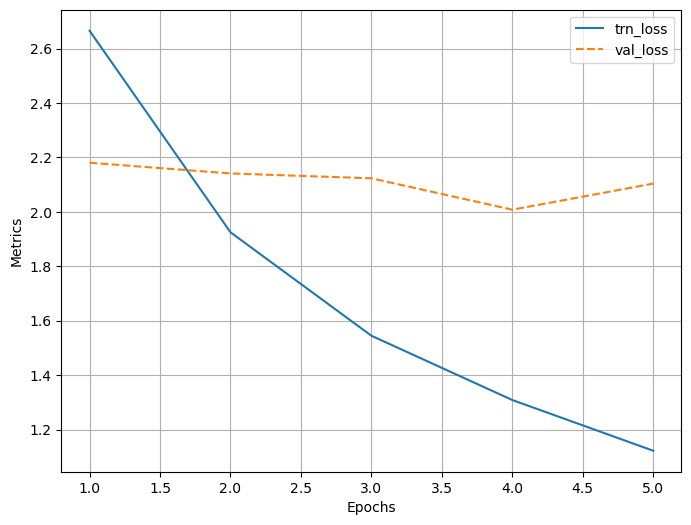

In [95]:
frcnn = FRCNN().to(device)
criterion = frcnn.calc_loss
optimizer = optim.SGD(frcnn.parameters(), lr=1e-3)

n_epochs = 5
log = Report(n_epochs)
for epoch in range(n_epochs):

    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss,regr_loss, accs = train_batch(inputs, \
                                 frcnn, optimizer, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), \
                   trn_loc_loss=loc_loss, \
                   trn_regr_loss=regr_loss, \
                   trn_acc=accs.mean(), end='\r')
        
    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(inputs, \
                                          frcnn, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), \
                val_loc_loss=loc_loss, \
                val_regr_loss=regr_loss, \
                val_acc=accs.mean(), end='\r')

# Plotting training and validation metrics
log.plot_epochs('trn_loss,val_loss'.split(','))

In [197]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from torchvision.ops import nms
from PIL import Image

def test_predictions(filename):
    img = cv2.resize(np.array(Image.open(filename)), (224,224))
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = preprocess_image(img/255.)[None]
    rois = [[x/224,y/224,X/224,Y/224] for x,y,X,Y in candidates]
    rixs = np.array([0]*len(rois))
    rois, rixs = [torch.Tensor(item).to(device) for item in [rois, rixs]]
    with torch.no_grad():
        frcnn.eval()
        probs, deltas = frcnn(input, rois, rixs)
        confs, clss = torch.max(probs, -1)
        print(torch.max(probs,-1))
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]
    
    ixs = clss!=1
    print(background_class)
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = candidates + deltas
    print(confs)
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.01)
    print(ixs)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    print(clss)
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    
    bbs = bbs.astype(np.uint16)
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title(filename.split('/')[-1])
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    else:
        
        show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1])
        plt.show()

C:\Users\rd238422\AppData\Local\miniconda3\envs\learnTorch\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


torch.return_types.max(
values=tensor([2.3567, 1.8837, 1.4788, 3.9025, 3.6470, 2.8030, 1.4788, 3.9025, 2.3567,
        3.9025, 2.3567, 3.0916, 3.5398, 3.1270, 3.5398, 2.8030, 3.5398, 3.5398,
        4.0781, 4.0781, 4.0781, 4.0781, 1.9136, 3.1270, 3.3298, 3.2484, 2.8030,
        2.8030, 2.8030, 2.3567, 1.0993, 1.8245, 2.6120, 3.2484, 2.6120, 1.1174,
        2.6120, 1.0215, 1.0215, 1.0215, 1.0215, 0.7451], device='cuda:0'),
indices=tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0'))

1

[3.091636   3.1270282  1.9135557  3.1270282  3.248388   3.248388
 1.0215231  1.0215231  1.0215231  1.0215231  0.74512255]

tensor([4])

0

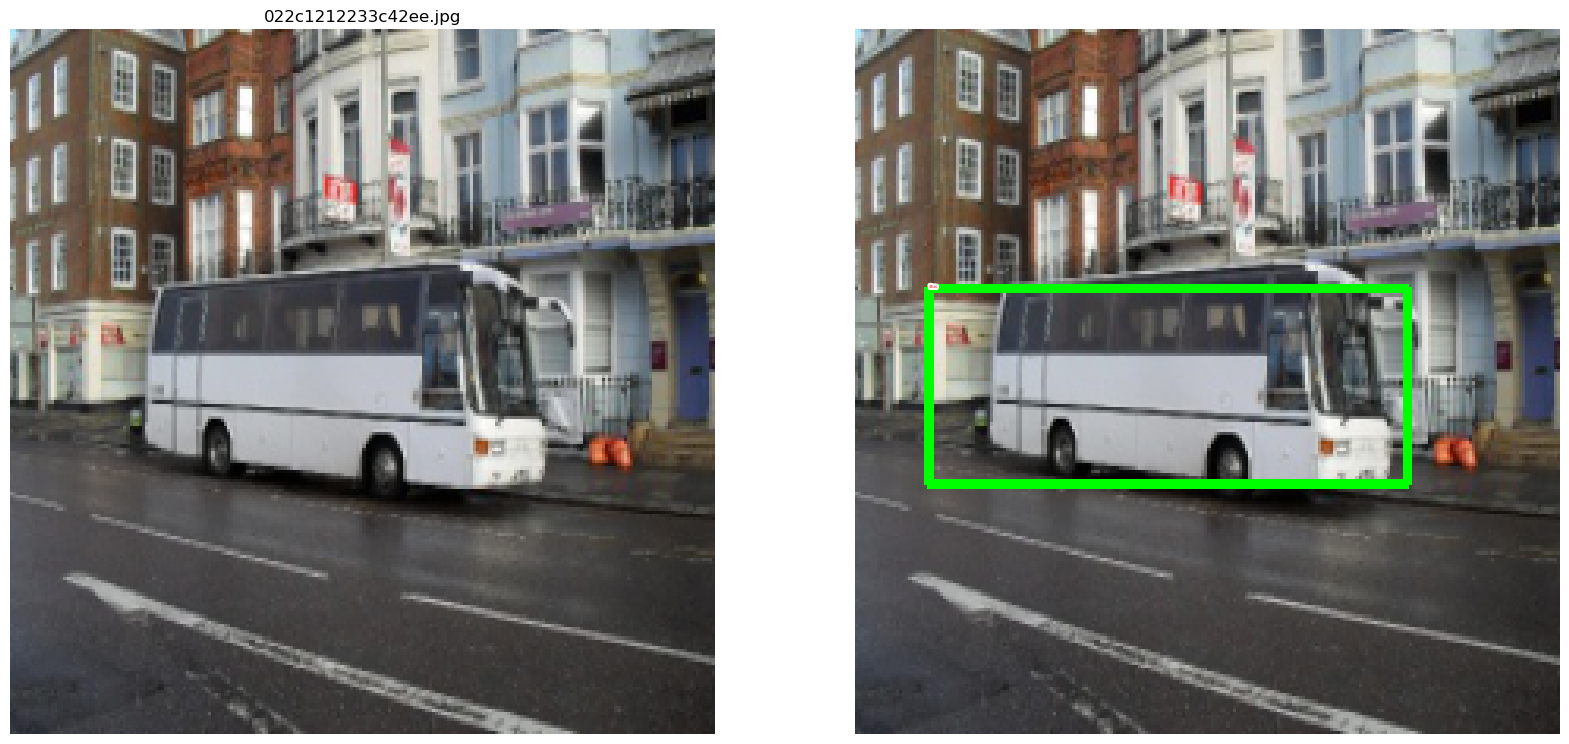

In [199]:
#test_predictions(test_ds[29][0])
test_predictions(test_ds.fpaths[38])